# Imports

In [22]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

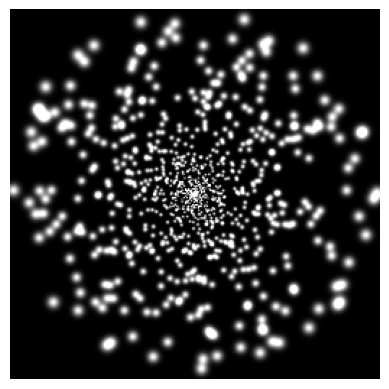

In [24]:
resolution = [256, 256]
params['run']['resolution'] = resolution # Resolution of the phosphene image

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.imshow(phosphenes.cpu()[0], cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [28]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

# stim_weights = torch.ones(n_phosphenes).cuda().detach()

Loss = 0.0033: 100%|██████████| 2000/2000 [01:08<00:00, 29.20iter/s]


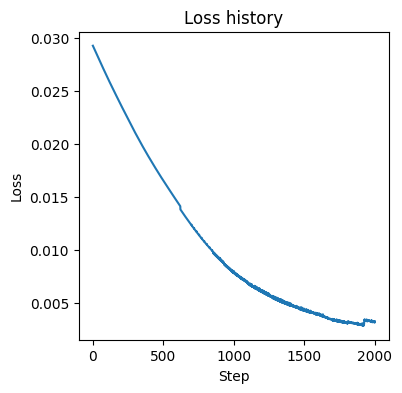

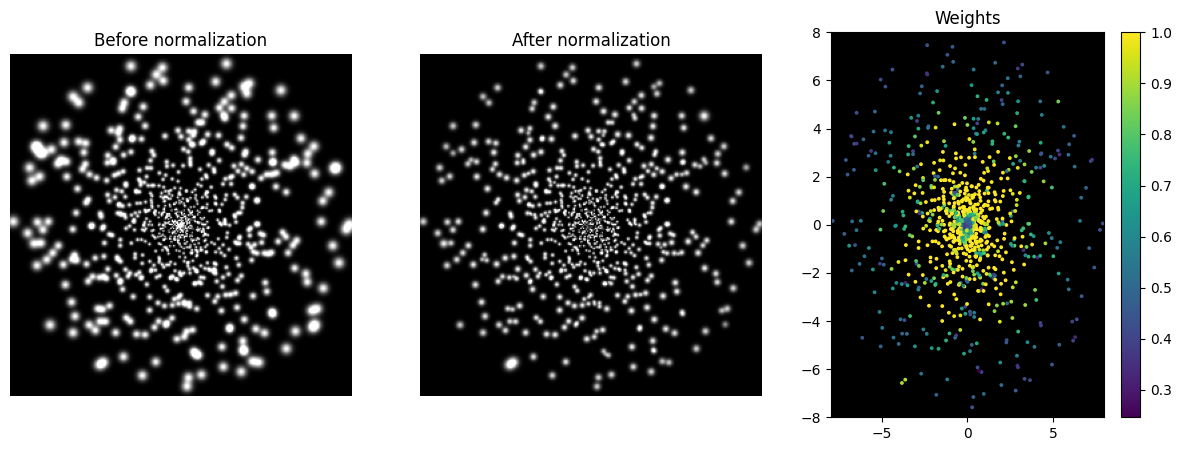

Percentage of amplitude: 76.51%


In [29]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [30]:
from phosphene.density import VisualFieldMapper

In [7]:
# compare different maps of different simulator resolutions
res1 = [256, 256]
res2 = [128, 128]
res3 = [64, 64]
res4 = [32, 32]

# create a list of resolutions
resolutions = [res1]#, res2, res3, res4]

maps = {}
# create a list of maps
for res in resolutions:
    # create a new simulator with the new resolution
    params['run']['resolution'] = res
    simulator = PhospheneSimulator(params, phosphene_coords)
    # create a new map
    mapper = VisualFieldMapper(simulator=simulator)
    density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
    sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
    sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

    # add the map to the dict
    maps[res[0]] = {
        'density_cortical': density_cortical,
        'sigma_cortical_fov': sigma_cortical_fov,
        'sigma_cortical_pix': sigma_cortical_pix
    }

# print the values of the maps: min, max, mean
for res, map in maps.items():
    print(f'Resolution: {res}')
    print(f'Density cortical: min: {map["density_cortical"].min()}, max: {map["density_cortical"].max()}, mean: {map["density_cortical"].mean()}')
    print(f'Sigma cortical fov: min: {map["sigma_cortical_fov"].min()}, max: {map["sigma_cortical_fov"].max()}, mean: {map["sigma_cortical_fov"].mean()}')
    print(f'Sigma cortical pix: min: {map["sigma_cortical_pix"].min()}, max: {map["sigma_cortical_pix"].max()}, mean: {map["sigma_cortical_pix"].mean()}')
    print()
    

Resolution: 256
Density cortical: min: 0.4393768624455172, max: 1861.2513181437225, mean: 3.9688110351562784
Sigma cortical fov: min: 0.01897142383010087, max: 1.234763673122778, mean: 0.6762066326387528
Sigma cortical pix: min: 0.3023570672922337, max: 19.679046040394343, mean: 10.77704320768016



In [36]:
# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=12, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

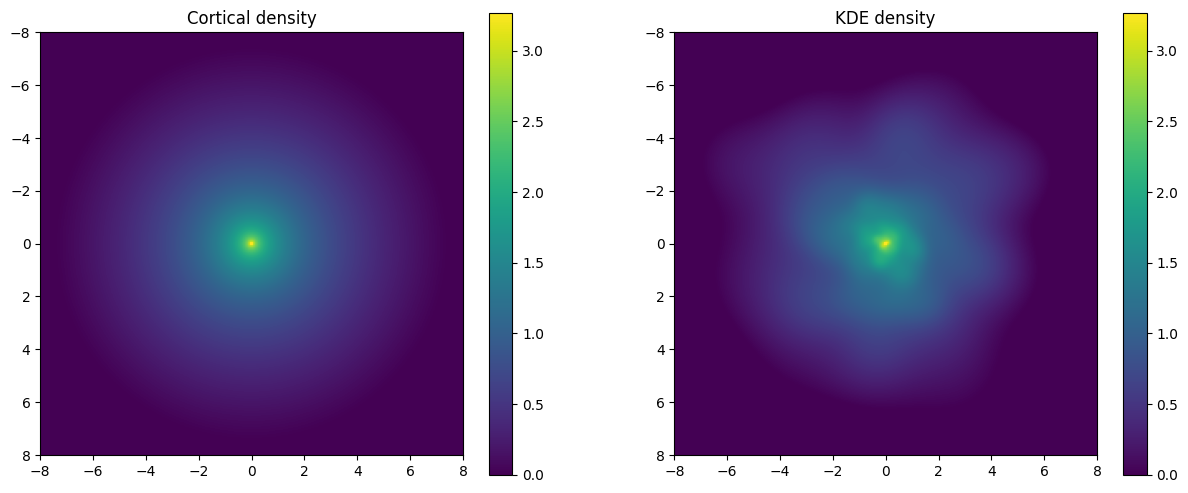

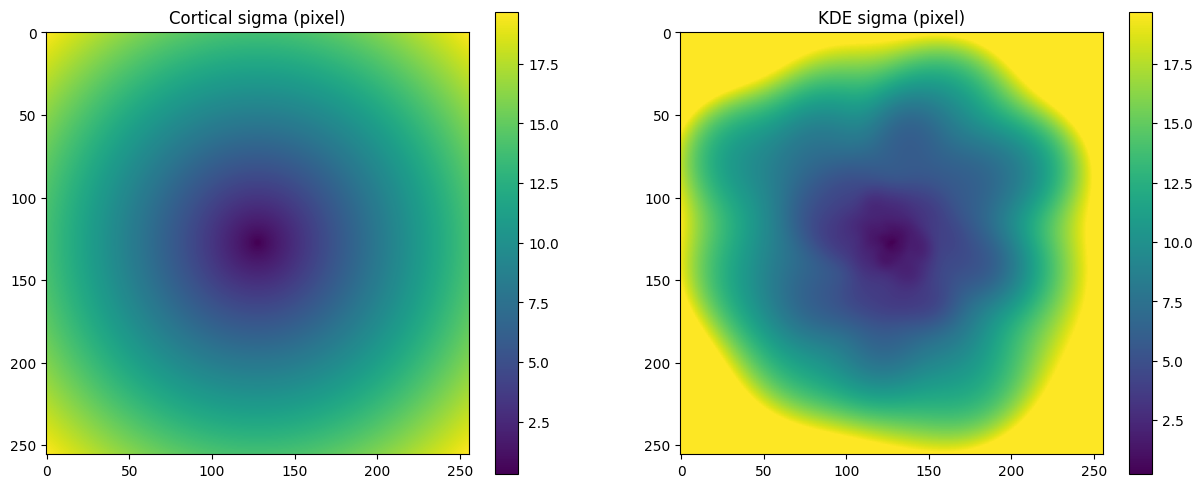

In [37]:
# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Separable Modulated 2D

In [38]:
from spatial_frequency.components.SeparableModulated2d import SeparableModulatedConv2d

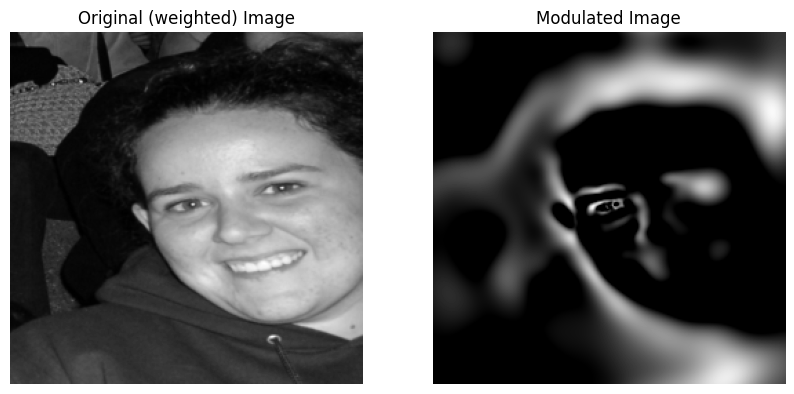

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# 1) Define your weighted‐grayscale Lambda
rgb_weights = torch.tensor([0.2126, 0.7152, 0.0722]).view(3,1,1)
to_weighted_grayscale = transforms.Lambda(
    lambda img: (img * rgb_weights).sum(dim=0, keepdim=True)
)

# 2) Build your full pipeline
t = transforms.Compose([
    transforms.Resize((res1[0], res1[1])),
    transforms.ToTensor(),            # → [C,H,W] in [0,1]
    to_weighted_grayscale,            # → [1,H,W] weighted luma
])

data_loader = DataLoader(
    ImageFolder('/projects/prjs0344/Dynaphos/data/example_faces_LaPa/', transform=t),
    batch_size=1,
    shuffle=False
)

# 3) Run exactly as before (now `images` is already weighted‐grayscale)
for i, (images, _) in enumerate(data_loader):
    images = images.cuda()                 # [B=1,1,H,W]
    modulated_images = mod_layer(images)   # no need to .mean() yourself
    modulated_images = modulated_images.detach().cpu().clip(0, None).numpy()
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(images[0,0].cpu().numpy(), cmap='gray')
    plt.title('Original (weighted) Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(modulated_images[0,0], cmap='gray')
    plt.title('Modulated Image')
    plt.axis('off')
    plt.show()

    if i == 0:
        break


In [62]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


# Dilation is used for the reg-loss on the phosphene image: phosphenes do not have to map 1 on 1, small offset is allowed.
def dilation5x5(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[[0., 0., 1., 0., 0.],
                              [0., 1., 1., 1., 0.],
                              [1., 1., 1., 1., 1.],
                              [0., 1., 1., 1., 0.],
                              [0., 0., 1., 0., 0.]]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [63]:
# Test if it works with a batch size of > 1
batch_size = 4
test_imgs = torch.ones(batch_size, 1, resolution[0], resolution[1]).cuda()
test_imgs = mod_layer(test_imgs)
print(test_imgs.shape)

torch.Size([4, 1, 256, 256])


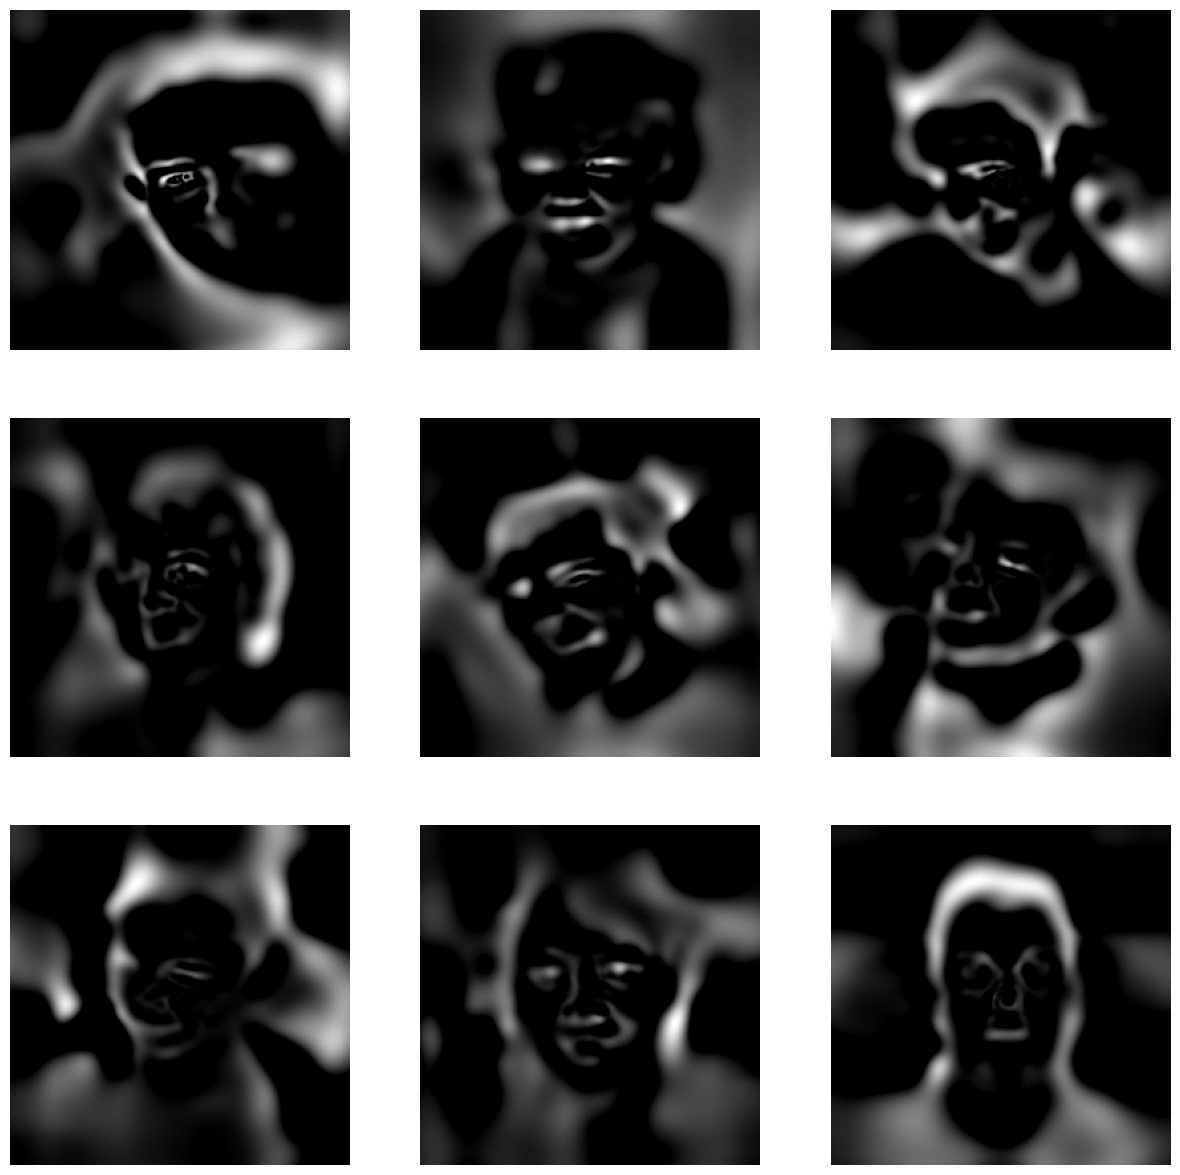

In [64]:
images = []
filtered_images = []

for img, _ in data_loader:
    img = img.cuda().detach()

    with torch.no_grad():
        filtered_img = mod_layer(img).detach().cpu().clip(0, None).numpy()

    # normalize between 0 and 1
    filtered_img = (filtered_img - filtered_img.min()) / (filtered_img.max() - filtered_img.min())
    
    filtered_images.append(filtered_img)
    images.append(img.cpu())

    # show filtered_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(filtered_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[0].transpose(1,2,0), cmap='gray')
    plt.axis('off')

plt.show()

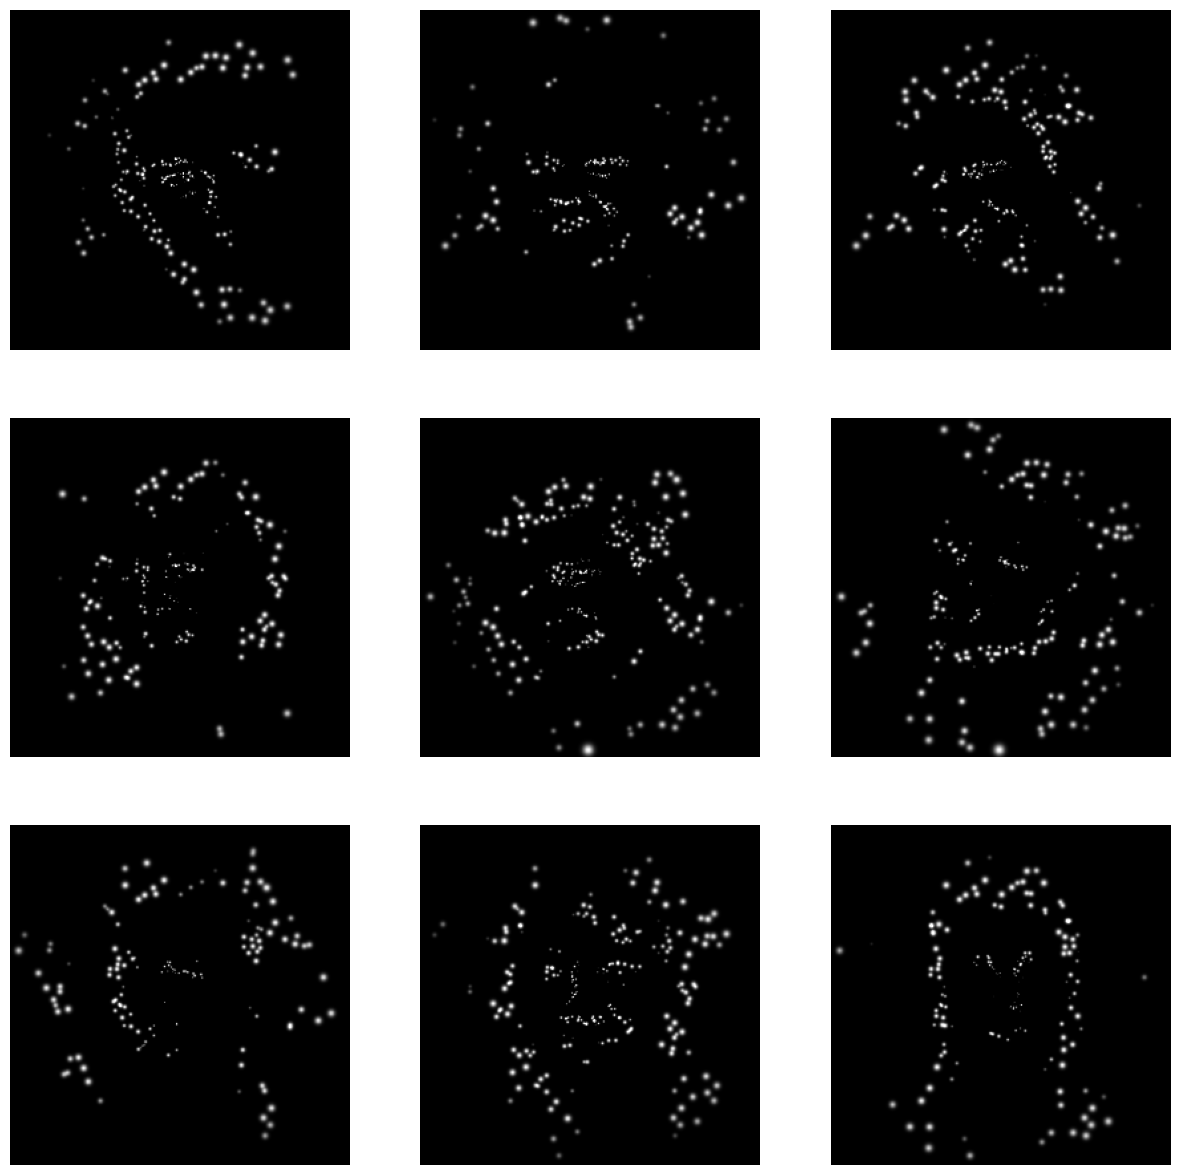

In [65]:
# show the images through the phosphene simulator
threshold = params['thresholding']['rheobase']

phos_images = []
for img in filtered_images:
    simulator.reset()
    stim = simulator.sample_stimulus(img[0].max(0), rescale=True)
    stim = robust_percentile_normalization(stim, amplitude, threshold=threshold, low_perc=5, high_perc=95, gamma=2/3)
    phos_img = simulator(stim * stim_weights)
    phos_images.append(phos_img)

# show phos_images
plt.figure(figsize=(15, 15))
for i, img in enumerate(phos_images[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(img.cpu()[0], cmap='gray')
    plt.axis('off')

plt.show()

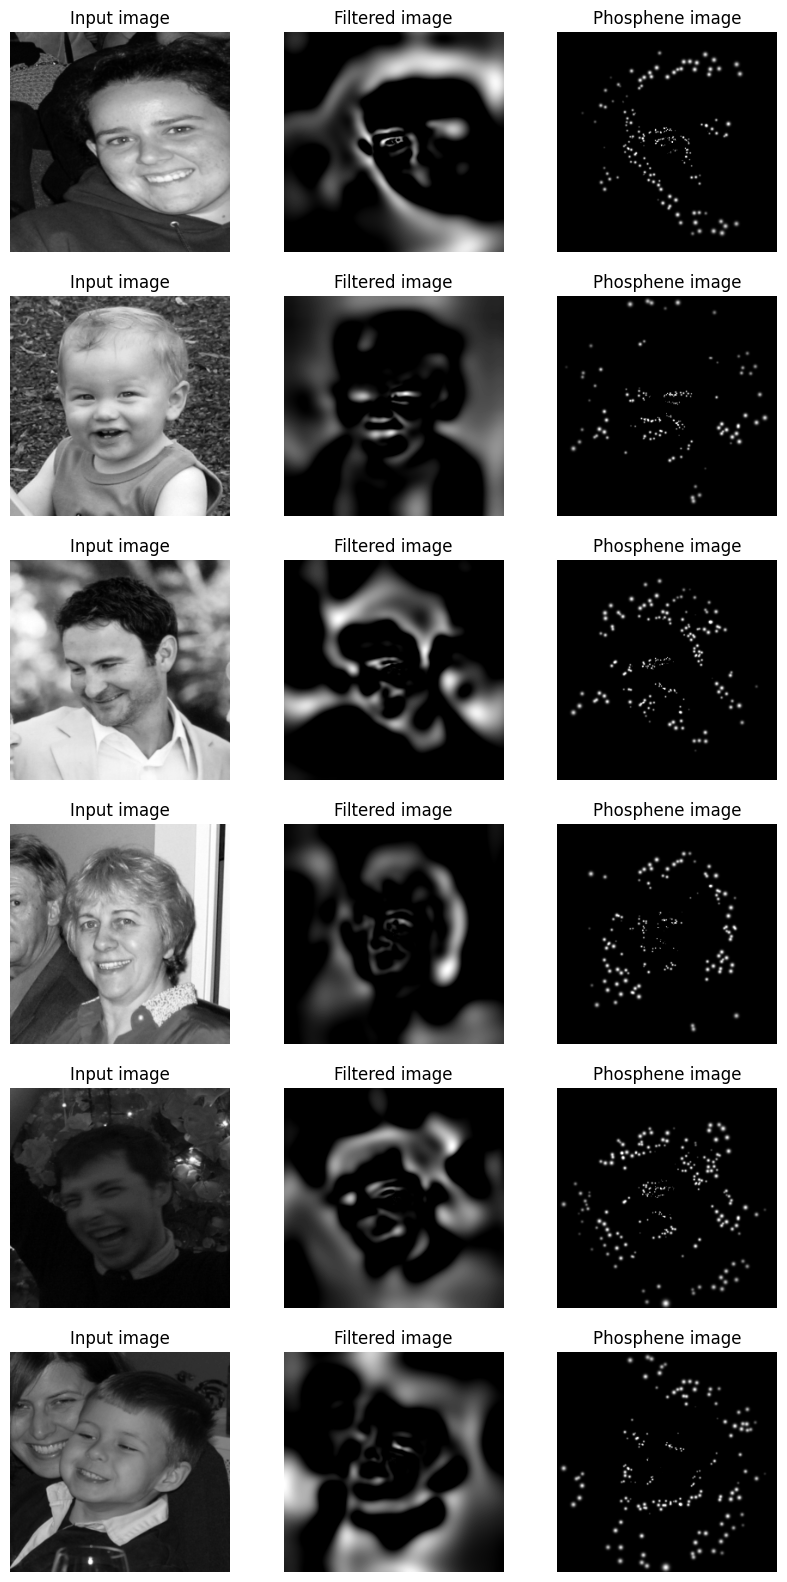

In [66]:
# show side by side:
# input image, filtered image and phosphene image

plt.figure(figsize=(10, 20))
imgs_to_show = 6

for i, (img, filtered_img, phos_img) in enumerate(zip(images, filtered_images, phos_images)):

    plt.subplot(imgs_to_show, 3, 3*i+1)
    plt.imshow(img[0].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Input image')

    plt.subplot(imgs_to_show, 3, 3*i+2)
    plt.imshow(filtered_img[0].transpose(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title('Filtered image')

    plt.subplot(imgs_to_show, 3, 3*i+3)
    plt.imshow(phos_img.cpu()[0], cmap='gray')
    plt.axis('off')
    plt.title('Phosphene image')

    if i == imgs_to_show - 1:
        break